# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1700378361.zip, parmi :

data_BEN_1700285256.zip
data_BEN_1700211016.zip
data_BEN_1700378361.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-11-19.zip, parmi 

File-Export-2020-08-03-to-2023-11-18.zip
File-Export-2020-08-03-to-2023-11-17.zip
File-Export-2020-08-03-to-2023-11-19.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_bbe57720-9ba0-43e3-945d-43779857dfa9.zip, parmi :

polar-user-data-export_f0d563c7-e85b-4936-8f88-5b1843bede5e.zip
polar-user-data-export_bbe57720-9ba0-43e3-945d-43779857dfa9.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-11-19.zip, data_BEN_1700378361.zip, polar-user-data-export_bbe57720-9ba0-43e3-945d-43779857dfa9.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [8]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-11-05,71.390000,11.997500,2.968750,56.406250,39.547500,0.168056,1652.878000
2023-11-06,72.585556,12.208889,3.017778,57.343333,40.441111,0.168200,1674.136000
2023-11-07,71.396250,11.420000,3.001250,56.963750,40.222500,0.159952,1665.487000
2023-11-08,71.160000,11.268750,2.997500,56.877500,40.175000,0.158358,1663.651000
2023-11-09,70.664444,11.138889,2.977778,56.530000,39.843333,0.157631,1655.752000
2023-11-10,70.384286,11.045714,2.970000,56.351429,39.682857,0.156934,1651.713143
2023-11-11,71.765000,11.561250,3.011250,57.177500,40.411250,0.161099,1670.401000
2023-11-12,71.212222,11.544444,2.983333,56.666667,39.892222,0.162113,1658.824000
2023-11-13,70.830000,11.471111,2.968889,56.373333,39.606667,0.161953,1652.152000


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-11-05,71.148956,11.649818,2.975248,56.507202,39.709680,0.163736,1655.181376
2023-11-06,71.444035,11.767823,2.983910,56.675842,39.856778,0.164706,1659.006192
2023-11-07,71.525880,11.718775,2.990994,56.800425,39.993087,0.163829,1661.833478
2023-11-08,71.674452,11.690025,3.000024,56.968639,40.172169,0.163083,1665.663620
2023-11-09,71.635944,11.645295,3.000564,56.974354,40.188645,0.162538,1665.798020
2023-11-10,71.351862,11.529785,2.992401,56.813537,40.050686,0.161558,1662.156878
2023-11-11,71.335077,11.520142,2.992044,56.807109,40.046222,0.161461,1662.002592
2023-11-12,71.309680,11.455420,2.994127,56.844311,40.095468,0.160612,1662.852020
2023-11-13,71.058886,11.350023,2.987143,56.705740,39.976261,0.159720,1659.711449


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [12]:
# df_food.tail(15)

In [13]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [14]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-11-04,1809.2,13.8,231.3,200.0
2023-11-05,3919.0,136.8,552.4,126.1
2023-11-06,528.5,5.3,75.1,50.0
2023-11-07,1265.9,23.2,118.0,150.8
2023-11-08,1882.4,47.0,206.1,166.2
2023-11-09,1859.5,42.3,192.2,179.5
2023-11-10,2056.7,52.6,203.1,187.0
2023-11-11,1837.8,40.3,207.4,174.8
2023-11-12,1765.3,37.0,175.4,195.8


In [15]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-11-04,2084.428571,45.314286,262.785714,157.614286
2023-11-05,2356.728571,58.757143,306.042857,152.514286
2023-11-06,2086.528571,49.985714,280.614286,130.728571
2023-11-07,2024.185714,48.457143,272.942857,125.214286
2023-11-08,2050.400000,47.200000,275.457143,135.728571
2023-11-09,1892.014286,40.785714,238.071429,151.857143
2023-11-10,1903.028571,45.857143,225.457143,151.371429
2023-11-11,1907.114286,49.642857,222.042857,147.771429
2023-11-12,1599.442857,35.385714,168.185714,157.728571


In [16]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [17]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

  0%|          | 0/1738 [00:00<?, ?it/s]

100%|██████████| 1738/1738 [01:01<00:00, 28.43it/s]


In [18]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-10-30,1920.712,272.0
2023-10-31,5100.711,556.0
2023-11-02,5580.713,462.0
2023-11-03,2520.837,340.0
2023-11-04,2761.306,487.0
2023-11-05,5586.720,514.0
2023-11-06,960.712,103.0
2023-11-07,2820.737,431.0
2023-11-08,3720.713,312.0
2023-11-10,1920.838,258.0


In [19]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [20]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-11-18,453,5700


In [21]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [22]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-10-31,5100.711,556.0
2023-11-02,5580.713,462.0
2023-11-03,2520.837,340.0
2023-11-04,2761.306,487.0
2023-11-05,5586.720,514.0
2023-11-06,960.712,103.0
2023-11-07,2820.737,431.0
2023-11-08,3720.713,312.0
2023-11-10,1920.838,258.0
2023-11-11,5340.712,488.0


In [23]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-10-31,3014.953000,312.857143
2023-11-02,3503.078000,331.571429
2023-11-03,3549.363857,355.285714
2023-11-04,3669.287857,386.714286
2023-11-05,4124.533571,441.571429
2023-11-06,3490.244429,390.571429
2023-11-07,3618.819429,413.285714
2023-11-08,3421.676857,378.428571
2023-11-10,2898.837571,349.285714
2023-11-11,3301.676857,370.428571


In [24]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [25]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [26]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [27]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [28]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-11-04,71.882500,11.628750,3.013750,57.222500,40.442500,0.161774,1671.481000,1809.2,13.8,231.3,200.0,2761.306,487.0,433.580202,2105.061202,-295.861202
2023-11-05,71.390000,11.997500,2.968750,56.406250,39.547500,0.168056,1652.878000,3919.0,136.8,552.4,126.1,5586.720,514.0,407.123072,2060.001072,1858.998928
2023-11-06,72.585556,12.208889,3.017778,57.343333,40.441111,0.168200,1674.136000,528.5,5.3,75.1,50.0,960.712,103.0,84.384693,1758.520693,-1230.020693
2023-11-07,71.396250,11.420000,3.001250,56.963750,40.222500,0.159952,1665.487000,1265.9,23.2,118.0,150.8,2820.737,431.0,376.626148,2042.113148,-776.213148
2023-11-08,71.160000,11.268750,2.997500,56.877500,40.175000,0.158358,1663.651000,1882.4,47.0,206.1,166.2,3720.713,312.0,240.356853,1904.007853,-21.607853
2023-11-09,70.664444,11.138889,2.977778,56.530000,39.843333,0.157631,1655.752000,1859.5,42.3,192.2,179.5,0.000,0.0,0.000000,1655.752000,203.748000
2023-11-10,70.384286,11.045714,2.970000,56.351429,39.682857,0.156934,1651.713143,2056.7,52.6,203.1,187.0,1920.838,258.0,221.279243,1872.992386,183.707614
2023-11-11,71.765000,11.561250,3.011250,57.177500,40.411250,0.161099,1670.401000,1837.8,40.3,207.4,174.8,5340.712,488.0,384.746173,2055.147173,-217.347173
2023-11-12,71.212222,11.544444,2.983333,56.666667,39.892222,0.162113,1658.824000,1765.3,37.0,175.4,195.8,0.000,0.0,0.000000,1658.824000,106.476000
2023-11-13,70.830000,11.471111,2.968889,56.373333,39.606667,0.161953,1652.152000,1853.7,51.2,143.3,216.6,2257.087,254.0,210.839690,1862.991690,-9.291690


In [29]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'w') as f:
    df_all.to_csv(file_save)

In [30]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-11-04,70.988548,11.506706,2.975019,56.490391,39.721058,0.162083,1654.807784,2084.428571,45.314286,262.785714,157.614286,2554.897000,302.428571,253.425966,1908.233750,176.194822
2023-11-05,71.148956,11.649818,2.975248,56.507202,39.709680,0.163736,1655.181376,2356.728571,58.757143,306.042857,152.514286,3352.999857,375.857143,311.586405,1966.767780,389.960791
2023-11-06,71.444035,11.767823,2.983910,56.675842,39.856778,0.164706,1659.006192,2086.528571,49.985714,280.614286,130.728571,3215.857000,351.714286,290.015879,1949.022071,137.506501
2023-11-07,71.525880,11.718775,2.990994,56.800425,39.993087,0.163829,1661.833478,2024.185714,48.457143,272.942857,125.214286,2890.146429,333.857143,278.270374,1940.103852,84.081862
2023-11-08,71.674452,11.690025,3.000024,56.968639,40.172169,0.163083,1665.663620,2050.400000,47.200000,275.457143,135.728571,3421.676857,378.428571,312.607068,1978.270688,72.129312
2023-11-09,71.635944,11.645295,3.000564,56.974354,40.188645,0.162538,1665.798020,1892.014286,40.785714,238.071429,151.857143,2624.432143,312.428571,261.876622,1927.674642,-35.660357
2023-11-10,71.351862,11.529785,2.992401,56.813537,40.050686,0.161558,1662.156878,1903.028571,45.857143,225.457143,151.371429,2538.718000,300.714286,251.907173,1914.064051,-11.035479
2023-11-11,71.335077,11.520142,2.992044,56.807109,40.046222,0.161461,1662.002592,1907.114286,49.642857,222.042857,147.771429,2907.204571,300.857143,244.930883,1906.933475,0.180811
2023-11-12,71.309680,11.455420,2.994127,56.844311,40.095468,0.160612,1662.852020,1599.442857,35.385714,168.185714,157.728571,2109.101714,227.428571,186.770444,1849.622465,-250.179608
2023-11-13,71.058886,11.350023,2.987143,56.705740,39.976261,0.159720,1659.711449,1788.757143,41.942857,177.928571,181.528571,2294.298143,249.000000,204.835444,1864.546893,-75.789750


# Graphes

In [31]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [32]:
def plot_general(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

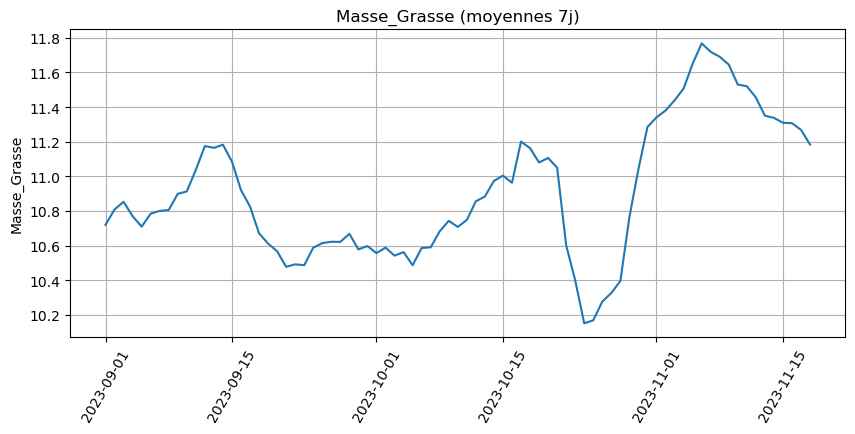

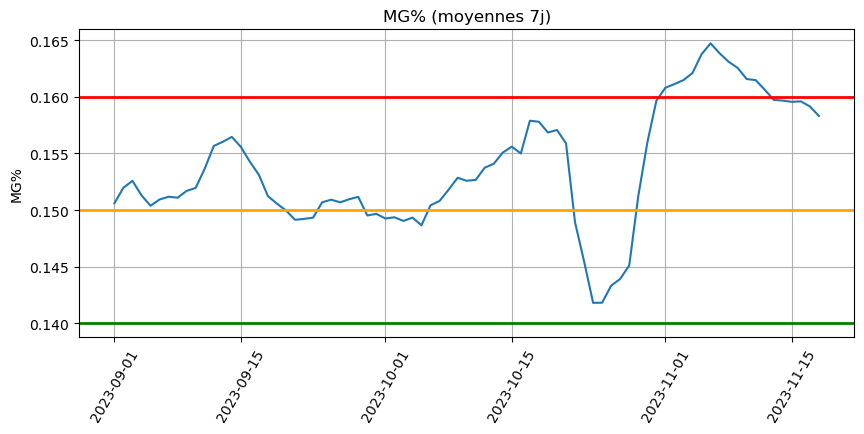

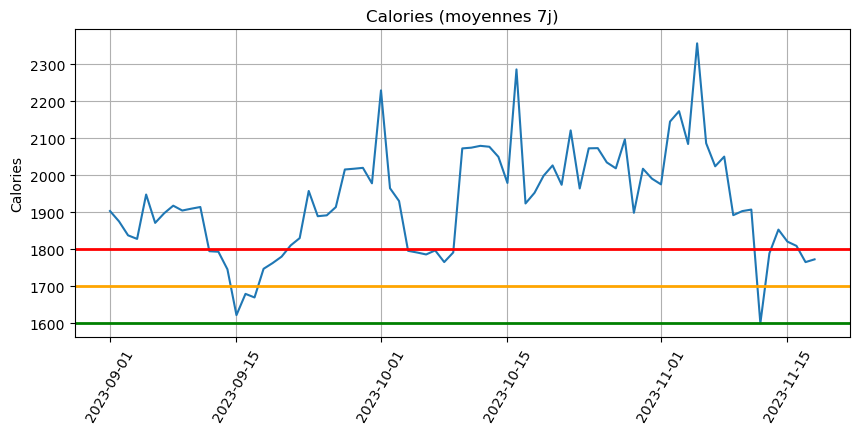

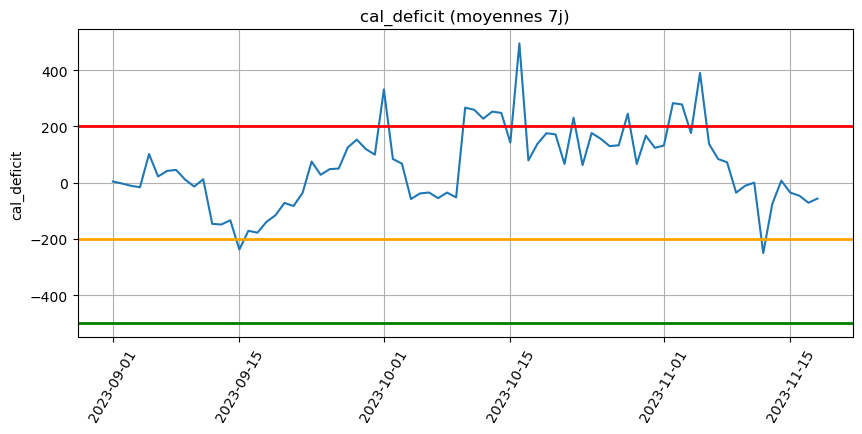

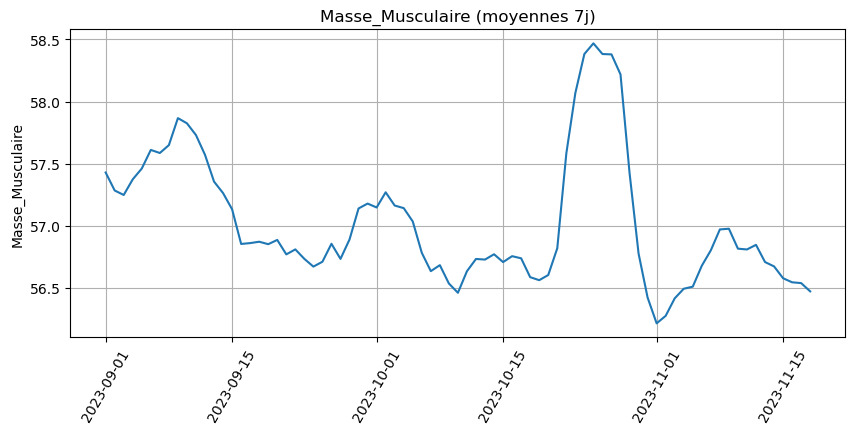

In [33]:
plot_general(longueur=7)

In [34]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=9, day=1)>

In [35]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [36]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general2(longueur=15, year=2023, month=9, day=1)>

In [37]:
def plot_general3(longueur=15,
                 year=2023,
                 month=9,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [38]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general3(longueur=15, year=2023, month=9, day=1)>

In [39]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [40]:
ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot(mass_interval=2.0, length=15)>

In [41]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [42]:
ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot2(mass_interval=2.0, length=15)>

In [43]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [44]:
ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=5.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot3(mass_interval=5.0, length=15)>